# 分类  Logistic Regression, LDA, QDA, and KNN
### （1）预测观测值属于某一定性变量的每一类的概率，作为进行分类的基础。
### （2）线性回归不再适合分类：
### （a）回归方法不能容纳两个以上类别的定性反应；
### （b）即使只有两个类，回归方法也不能提供Pr（Y |X）的有意义的估计，例如可能存在无法解释拟合概率值为负数情况


In [3]:
import numpy as np  # 导入 NumPy 库，常用于进行数组操作和数值计算
import matplotlib.pyplot as plt #画混淆矩阵
import pandas as pd  # 导入 Pandas 库，用于数据处理和分析，尤其是数据框（DataFrame）操作
from matplotlib.pyplot import subplots  # 从 Matplotlib 库导入 subplots 函数，用于创建多个子图
import statsmodels.api as sm  # 导入 Statsmodels 库，提供统计模型和计量经济学工具
from ISLP import load_data  # 从 ISLP 库导入 load_data 函数，用于加载数据集
from ISLP.models import (ModelSpec as MS,  # 从 ISLP 库导入 ModelSpec 类，作为 MS 使用，常用于定义模型规范
                         summarize)  # 从 ISLP 库导入 summarize 函数，用于生成模型结果的摘要


In [4]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score


In [5]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


### The Stock Market Data
### （1）1,250 天内标准普尔 500 指数的百分比回报数据，从 2001 年初到 2005 年底。
### （2）对于每个日期，记录了前五个交易日的百分比回报数据，分别为 `Lag1` 到 `Lag5`。
### （3）`Volume`（前一天的成交量，单位为十亿股）、`Today`（当天的百分比回报）
### （4）`Direction`（当天市场是 `Up`（上涨）还是 `Down`（下跌））。

In [18]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

利用 `corr()` 方法计算相关矩阵，该方法生成一个包含所有变量之间成对相关性的矩阵。

`pandas` 仅使用数值变量，`corr()` 方法不会报告 `Direction` 变量的相关性，因为它是定性的。

In [19]:
Smarket.corr(numeric_only=True)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


### 滞后回报变量与今天的回报之间的相关性接近于零。唯一显著的相关性是在 `Year` 和 `Volume` 之间。
### `Volume` 随着时间的推移在增加，从 2001 年到 2005 年，日均成交股数有所增加。


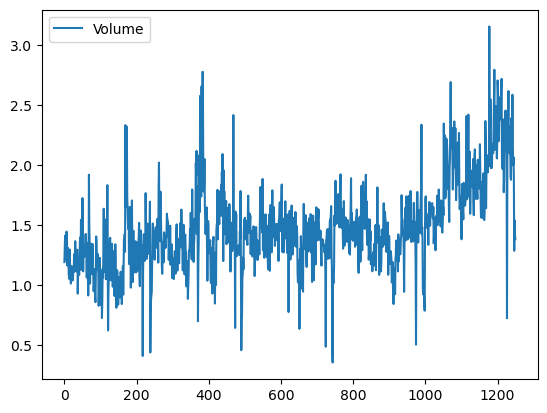

In [20]:
Smarket.plot(y='Volume');


## 1. Logistic Regression

### 原理
（1）Sigmoid 函数  
逻辑回归使用 **Sigmoid** 函数将线性回归的输出转换为概率：

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
其中 \( z = WX + b \)。Sigmoid 函数的值范围在 (0,1) 之间，适合作为概率解释。

（2） 对数几率（Logit）模型  
逻辑回归建模的是 **事件发生的对数几率**：
$$
\log \frac{Y}{1-Y} = \log \frac{P(Y=1)}{P(Y=0)} = WX + b
$$
其中：
- Y表示样本取正例，1-Y表示样本取反例。
- 左侧是**对数几率（log odds）**，表示事件发生（ \( Y=1 \) ）的几率的对数；
- 右侧是线性回归形式，保证决策边界仍然是线性的。

通过对数几率模型，逻辑回归可以拟合二分类问题，并输出类别发生的概率。

（3） 求解系数：极大似然估计


### 实操
1.使用的变量包括 `Lag1` 到 `Lag5` 和 `Volume`。
2. 2001 到 2004 年的数据来训练模型预测 `Direction`，然后用 2005 年的数据来测试模型（监督学习）

In [24]:
# 数据预处理
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])  # 从 Smarket 数据集去掉 'Today'、'Direction' 和 'Year' 列，保留其余变量
design = MS(allvars)  # 使用 ModelSpec（MS）来创建模型规范，指定用于拟合的自变量
X = design.fit_transform(Smarket)  # 对 Smarket 数据集应用设计矩阵，转换为适合模型的格式
y = Smarket.Direction == 'Up'  # 创建目标变量 y，'Direction' 列为 'Up' 时为 True，否则为 False

# 划分训练集和测试集
train = (Smarket.Year < 2005)  
Smarket_train = Smarket.loc[train]  
Smarket_test = Smarket.loc[~train]  

# 准备特征矩阵和目标向量
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

D = Smarket.Direction  # 从 Smarket 数据集中提取目标变量 'Direction'，存储在变量 D 中。
L_train, L_test = D.loc[train], D.loc[~train]  # 将 'Direction' 列分为训练集 (L_train) 和测试集 (L_test)。'train' 为 True 的部分作为训练集，'train' 为 False 的部分作为测试集。

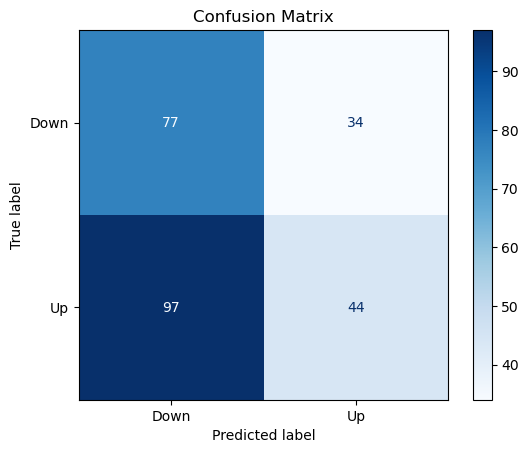

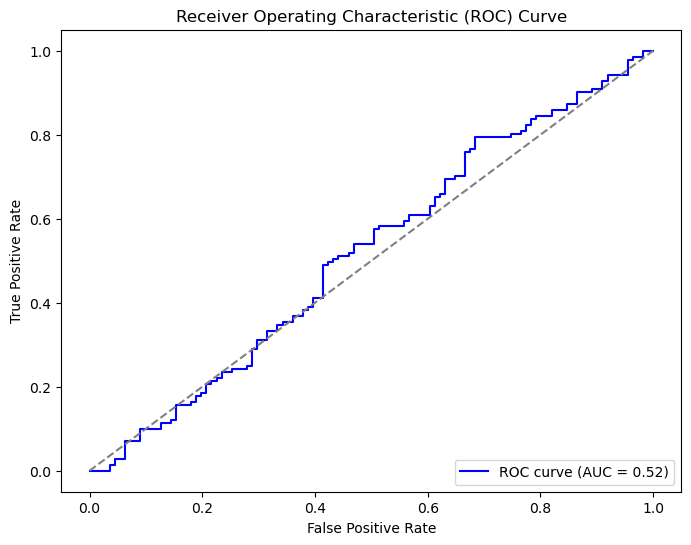

In [26]:
# 使用 statsmodels 拟合逻辑回归模型
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()

# 对测试集进行概率预测
probs = results.predict(exog=X_test)

# 根据预测的概率分配 'Up' 或 'Down'
labels = np.array(['Down'] * len(Smarket_test))
labels[probs > 0.5] = 'Up'


# 计算混淆矩阵
conf_matrix = confusion_matrix(L_test, labels)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(L_test == 'Up', probs)  # L_test == 'Up' 作为真阳性标签
roc_auc = roc_auc_score(L_test == 'Up', probs)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1. ROC曲线概述
ROC曲线（Receiver Operating Characteristic Curve）是评估二分类模型性能的工具，通过展示不同阈值下的 真阳性率（TPR） 和 假阳性率（FPR）。
TPR：也叫召回率，表示模型正确预测正类的比例。
FPR：表示模型错误预测负类为正类的比例。
2. AUC（曲线下面积）
AUC（Area Under the Curve）是ROC曲线下的面积，表示模型的分类能力。
AUC = 0.5：模型与随机猜测无异。
AUC > 0.5：模型有一定的分类能力。
AUC接近1：模型的分类能力较强。
3. 如何解读ROC曲线
理想曲线：曲线尽量接近左上角，表示高TPR和低FPR，模型分类效果好。
随机猜测：曲线接近对角线（45°线），表示模型无辨别能力。
AUC值：AUC越大，模型越强，AUC接近1表示非常好，接近0.5表示无效。

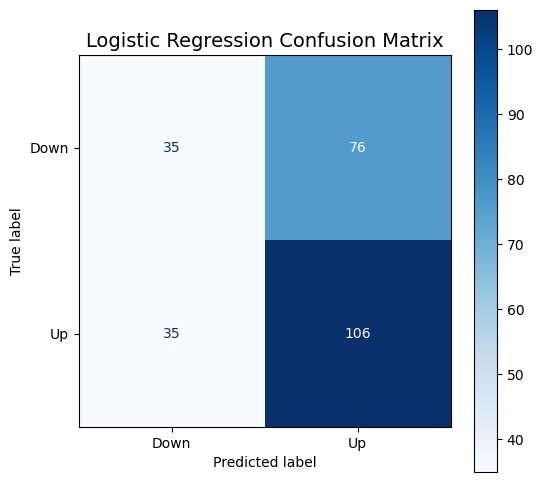

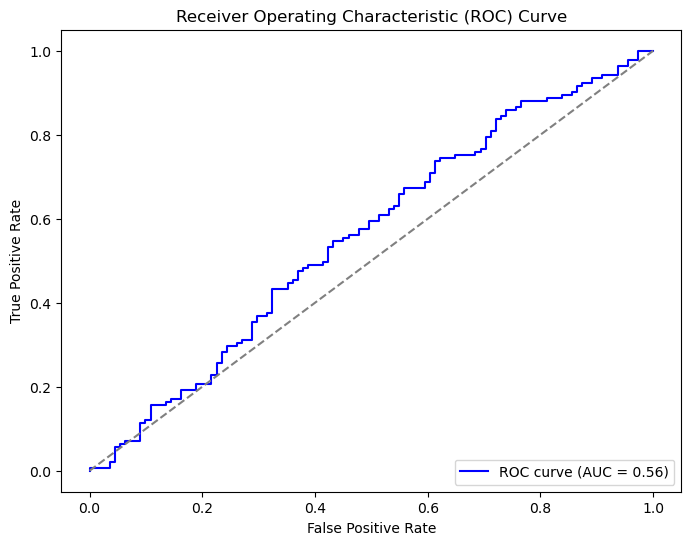

In [28]:
# 选择Lag1 和Lag2 作为预测变量（观察了预测变量的显著性；可采用逐步向前法）
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
# 划分训练集和测试集（2001到2004年为训练集，2005年为测试集）
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

# 训练逻辑回归模型
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()

# 进行预测
probs = results.predict(exog=X_test)

# 根据预测概率生成标签（阈值为0.5）
labels = np.array(['Down'] * len(X_test))
labels[probs > 0.5] = 'Up'

# 计算混淆矩阵并可视化
conf_matrix = confusion_matrix(L_test, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])

# 设置图表样式并显示混淆矩阵
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Logistic Regression Confusion Matrix", fontsize=14)
plt.show()

# 可选：绘制ROC曲线
fpr, tpr, _ = roc_curve(L_test == 'Up', probs)
roc_auc = roc_auc_score(L_test == 'Up', probs)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Linear Discriminant Analysis

## 原理

### LDA是一种监督学习方法，主要用于分类任务。

### 1. **最大化类间方差与类内方差比**：
   LDA的核心目标是找到一个线性组合的特征，使得不同类别之间的差异（类间方差）尽可能大，而同一类别内的差异（类内方差）尽可能小。这是为了确保不同类别的样本尽可能分开，同时让同一类别的样本尽可能聚集在一起。

### 2. **通过寻找最佳投影方向进行降维**：
   LDA通过投影将高维数据映射到低维空间，通常是将数据降到一个低于特征空间维度的维度（例如，2或3维）。这种投影最大化了类别间的可分性。LDA的结果是找到一个或多个新的轴，数据在这些轴上的投影能够使不同类别的数据点尽可能远离。

### 3. **假设每个类别的特征分布是高斯分布**：
   LDA假设每个类别的样本数据来自一个高斯分布，且所有类别共享相同的协方差矩阵（即每个类别的特征之间的相关性是相同的）。这个假设使得LDA能够通过最大化类间和类内方差比来找到最佳的分隔线。

### 通过这三点，LDA能够有效地将数据分为不同的类别，并广泛应用于模式识别、文本分类等任务中。
### 函数：`LinearDiscriminantAnalysis()`, 简化 `LDA()`.

In [31]:
lda = LDA(store_covariance=True)
# LDA线性判别分类，储存协方差
# 由于 LDA（线性判别分析）估计器会自动添加截距项，因此在 X_train 和 X_test 中去掉与截距项对应的列

In [ ]:
# 使用列表推导式移除 X_train 和 X_test 中的 'intercept' 列
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]


In [35]:
# 使用LDA拟合训练数据
lda.fit(X_train, L_train)

# 获取每个类别的均值
lda.means_
# 第一行表示类别 Up（上涨）在 Lag1 和 Lag2 上的均值。
# 第二行表示类别 Down（下跌）在 Lag1 和 Lag2 上的均值。

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [36]:
# 获取模型的类别标签
lda.classes_


array(['Down', 'Up'], dtype='<U4')

In [37]:
# 获取每个类别的先验概率，Down的先验概率是0.49，up的先验概率是0.51
lda.priors_

array([0.49198397, 0.50801603])

In [38]:
# 获取每个特征的加权系数（判别函数）
lda.scalings_


array([[-0.64201904],
       [-0.51352928]])

### 这些值提供了 Lag1 和 Lag2 的线性组合，用于构建 LDA 决策规则。如果 $-0.64\times `Lag1`  - 0.51 \times `Lag2` $ 值较大，那么 LDA 分类器将预测市场上涨；如果值较小，则 LDA 分类器将预测市场下跌。

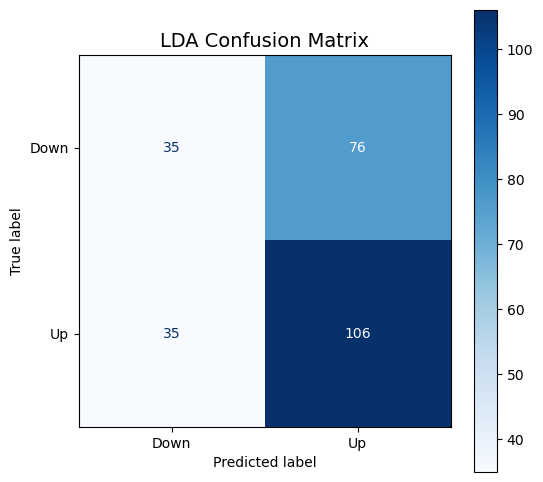

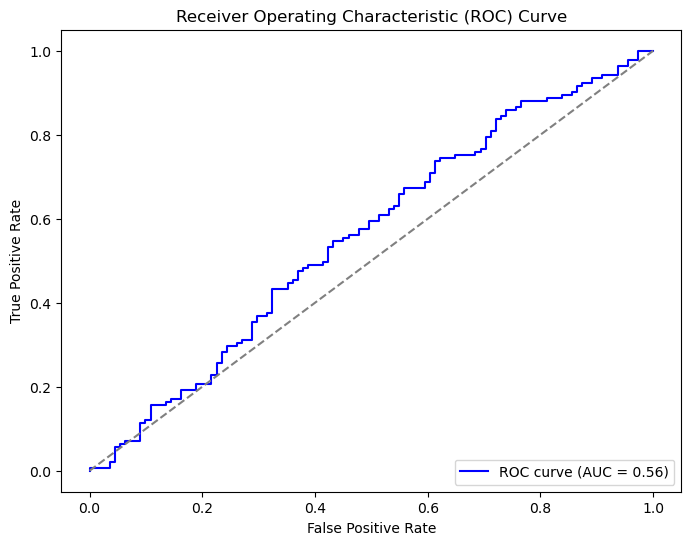

In [42]:
# 对测试集进行分类预测
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)
# 设置图表样式并显示混淆矩阵
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("LDA Confusion Matrix", fontsize=14)
plt.show()

# 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(L_test == 'Up', lda_prob[:, 1])  # 计算假阳性率和真正率
roc_auc = roc_auc_score(L_test == 'Up', lda_prob[:, 1])  # 计算AUC

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [40]:
# 计算测试集每个样本属于各个类别的概率
lda_prob = lda.predict_proba(X_test)

# 通过后验概率重新生成分类结果，阈值为0.5
np.where(lda_prob[:,1] >= 0.5, 'Up', 'Down')

# 比较通过概率分类得到的结果与 LDA 模型的预测结果
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up', 'Down') == lda_pred)


True

In [41]:
np.all(
       [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
       )
# np.argmax 自动选择概率最大的类别，没有设定固定的阈值，直接选择概率最大类。

True

### 代码解释：lda_prob = lda.predict_proba(X_test)

该变量存储了 X_test 每个样本属于不同类别的后验概率。
lda_prob 的形状为 (n_samples, n_classes)，其中 lda_prob[i, j] 表示第 i 个样本属于 j 类的概率。

### np.argmax(lda_prob, 1)
计算 lda_prob 每一行（即每个样本）的最大概率对应的索引。
np.argmax(lda_prob, 1) 返回一个数组，其中每个值都是 lda_prob 该行最大值的索引，即模型预测的类别索引。
[lda.classes_[i] for i in np.argmax(lda_prob, 1)]

### np.all() 检查数组中的所有元素是否都为 True，如果是，则返回 True，否则返回 False。
这意味着 lda.predict_proba(X_test) 计算出的最大概率类别与 lda.predict(X_test) 直接预测的类别是否完全一致，即 predict_proba() 返回的最大后验概率类别与 predict() 返回的类别是否相同。（ LDA计算的后验概率 和 LDA自动分类方法 可以用来衡量模型的准确性或区别它们的表现。）




In [43]:
np.sum(lda_prob[:,0] > 0.9)
# 计算测试集中有多少个样本的“Down”类别（即 lda_prob 的第0列）后验概率大于 0.9

0

### 使用不同于 50% 的后验概率阈值来进行预测
假设仅在非常确定市场会下跌的情况下才预测市场下跌——比如，当后验概率至少为 90% 时。  
没有任何样本被 LDA 模型分配到 "Down" 类别的概率超过 0.9。

## Quadratic Discriminant Analysis
‘ QuadraticDiscriminantAnalysis() ’实现的，缩写为‘ QDA() ’
### 原理
1. **模型假设**：
   - QDA 假设每个类别的数据点来自于一个高斯分布（正态分布），并且每个类别的高斯分布具有不同的均值和协方差矩阵。
   - 与 LDA（线性判别分析）不同，QDA 不假设各类别的协方差矩阵相同。每个类别都有自己的协方差矩阵，这使得 QDA 能够捕捉到不同类别之间更加复杂的关系。

2. **判别函数**：
   - 在 QDA 中，目标是通过计算每个类别的后验概率来进行分类。QDA 使用贝叶斯定理来计算每个类别的后验概率，并选择具有最大后验概率的类别。
   - 由于每个类别的协方差矩阵不同，QDA 的决策边界是二次曲线（而不是 LDA 的线性决策边界）。这使得 QDA 可以更灵活地拟合非线性的数据分布。

3. **优势与劣势**：
   - **优势**：QDA 能够处理各类别具有不同协方差的情况，适用于数据分布更复杂的场景。
   - **劣势**：由于每个类别都需要估计自己的协方差矩阵，QDA 在数据样本较少时可能会面临过拟合的风险，尤其是在类别数多或者特征空间较大的情况下。

In [44]:
# 创建一个QDA（Quadratic Discriminant Analysis，二次判别分析）分类器的实例
qda = QDA(store_covariance=True)  # store_covariance=True表示在拟合过程中会保存协方差矩阵

# 使用训练数据拟合QDA模型
qda.fit(X_train, L_train)  # X_train是特征矩阵，L_train是对应的标签


QuadraticDiscriminantAnalysis(store_covariance=True)

In [45]:
qda.means_, qda.priors_


(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

‘ QDA() ’分类器将对每个类估计一个协方差。第一类的协方差估计如下：

In [46]:
qda.covariance_[0]


array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

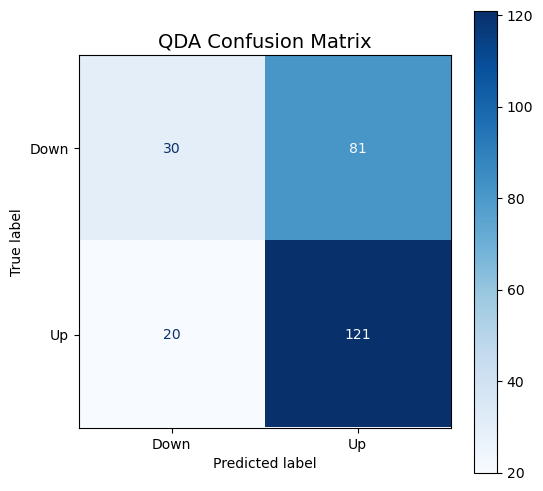

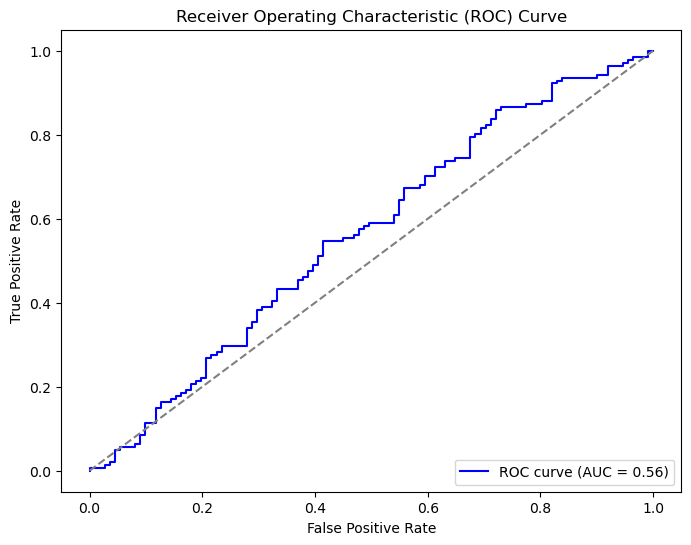

In [48]:
# 使用训练好的QDA模型对测试数据进行预测
qda_pred = qda.predict(X_test)  # X_test是测试数据，返回的是预测结果

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(L_test, qda_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])

# 设置图表样式并显示混淆矩阵
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("QDA Confusion Matrix", fontsize=14)
plt.show()

# 计算测试集每个样本属于各个类别的概率
qda_prob = qda.predict_proba(X_test)

# 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(L_test == 'Up', qda_prob[:, 1])  # 计算假阳性率和真正率
roc_auc = roc_auc_score(L_test == 'Up', qda_prob[:, 1])  # 计算AUC

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


尽管2005年的数据没有被用来拟合模型，但QDA预测的准确率几乎达到了60%。

In [49]:
# 计算QDA模型预测结果与真实标签之间的准确率
np.mean(qda_pred == L_test)  # 比较预测结果(qda_pred)与真实标签(L_test)是否相等，返回一个布尔数组，求平均值即为准确率


0.5992063492063492

与LDA和逻辑回归假设的线性形式相比，QDA假设的二次形式可能更准确地捕捉到真实的关系。

## Naive Bayes
### 朴素贝叶斯模型：‘ GaussianNB() ’使用高斯分布对每个定量特征进行建模。核密度法也可以用来估计分布。
## 原理

### 朴素贝叶斯分类是一种基于概率的分类方法，核心思想是通过计算每个类别的后验概率来做分类决策。它的"朴素"之处在于假设特征之间是相互独立的，这让算法变得简单且高效。

### 1. **贝叶斯定理**
朴素贝叶斯的基础是贝叶斯定理，它通过已知的先验概率（类别出现的概率）和似然概率（特征在某个类别下的概率）来推算出后验概率（给定特征，样本属于某个类别的概率）。在分类时，我们根据每个类别的后验概率来选择最可能的类别。

### 2. **特征独立假设**
朴素贝叶斯的一个重要假设是特征之间相互独立。这意味着在计算样本属于某个类别的概率时，每个特征对结果的影响是独立的，换句话说，某个特征的出现与其他特征无关。这个假设使得计算变得简单而快速。

### 3. **分类决策**
当我们有了每个类别的后验概率后，朴素贝叶斯会选择概率最大的类别作为预测结果。


In [50]:
NB = GaussianNB()  # GaussianNB()表示使用高斯分布假设的朴素贝叶斯分类器

# 使用训练数据拟合高斯朴素贝叶斯模型
NB.fit(X_train, L_train)  # X_train是训练数据的特征，L_train是对应的标签


GaussianNB()

In [114]:
NB.classes_


array(['Down', 'Up'], dtype='<U4')

In [115]:
NB.class_prior_


array([0.49198397, 0.50801603])

特征的参数可以在‘ theta ’和‘ var ’属性中找到。行数等于类的数量，列数等于特征的数量。
例如：特征“Lag1”在“Down”类中的平均值是0.043。

In [116]:
# 获取高斯朴素贝叶斯模型的均值参数
NB.theta_  # NB.theta_是模型训练后每个特征的类条件均值，形状为（类数，特征数）


array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [117]:
# 获取高斯朴素贝叶斯模型的方差参数
NB.var_  # NB.var_是模型训练后每个特征的类条件方差，形状为（类数，特征数）

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [118]:
# 计算标签为'Down'的样本在X_train中的特征均值
X_train[L_train == 'Down'].mean()  # 选择L_train中标签为'Down'的样本，计算对应特征的均值


Lag1    0.042790
Lag2    0.033894
dtype: float64

In [119]:
# 计算标签为'Down'的样本在X_train中的特征方差
X_train[L_train == 'Down'].var(ddof=0)  # 选择L_train中标签为'Down'的样本，计算对应特征的方差，ddof=0表示计算总体方差


Lag1    1.503554
Lag2    1.532467
dtype: float64

预测

In [120]:
# 使用训练好的高斯朴素贝叶斯模型对测试数据进行预测
nb_labels = NB.predict(X_test)  # X_test是测试数据，返回的是预测结果

# 调用混淆矩阵函数，评估高斯朴素贝叶斯模型在测试数据上的表现
confusion_table(nb_labels, L_test)  # nb_labels是模型的预测结果，L_test是测试数据的真实标签


Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


朴素贝叶斯在这些数据上表现良好，预测准确率超过59%。这比QDA略差，但比LDA好得多。

In [46]:
# 获取高斯朴素贝叶斯模型对测试数据的预测概率
NB.predict_proba(X_test)[:5]  # 返回测试数据X_test的前5个样本的预测概率


array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## K-Nearest Neighbors
 `KNeighborsClassifier()` 
## 原理

### 1. **计算距离**：对于每一个待分类的样本，KNN会计算它与训练集中所有其他样本的距离（通常使用欧氏距离或其他距离度量方式）。

### 2. **选择最近邻**：根据计算的距离，选择离待分类样本最近的K个训练样本。K是一个预先设定的参数。

### 3. **投票决策**：K个最近邻中，大多数样本所属的类别将作为待分类样本的预测类别。即根据邻居们的标签进行"投票"，投票最多的类别被选为最终分类结果。


In [121]:
# 创建一个K近邻分类器实例，设置K（可调参数）为1
knn1 = KNeighborsClassifier(n_neighbors=1)  # n_neighbors=1表示使用1个最近邻来进行分类

# 将X_train和X_test转换为numpy数组
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]  # 确保X_train和X_test是numpy数组格式，便于进行K近邻计算

# 使用训练数据拟合K近邻分类器
knn1.fit(X_train, L_train)  # X_train是训练数据的特征，L_train是对应的标签

# 使用K近邻模型对测试数据进行预测
knn1_pred = knn1.predict(X_test)  # X_test是测试数据，返回的是预测结果

# 调用混淆矩阵函数，评估K近邻模型在测试数据上的表现
confusion_table(knn1_pred, L_test)  # knn1_pred是模型的预测结果，L_test是测试数据的真实标签


Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


使用K=1的结果不是很好，因为只有50%的观测值被正确预测。当然，K=1可能会导致对数据的拟合过于灵活。

In [122]:
(83+43)/252, np.mean(knn1_pred == L_test)
# 计算K近邻模型预测结果与真实标签之间的准确率
#np.mean(knn1_pred == L_test)  # 比较knn1_pred和L_test是否相等，返回布尔数组，求均值即为准确率

(0.5, 0.5)

如何调参：使用循环语句。假设 $K=3$.

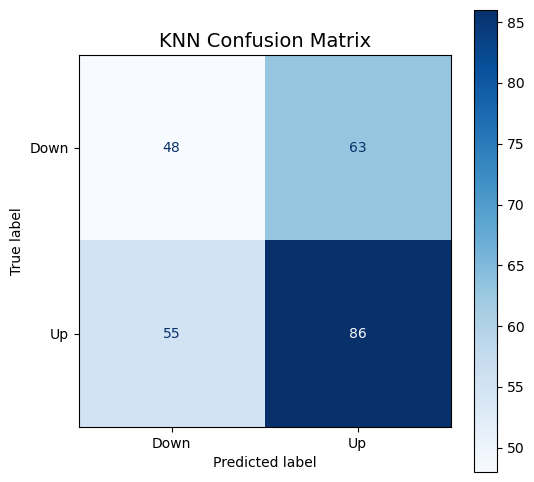

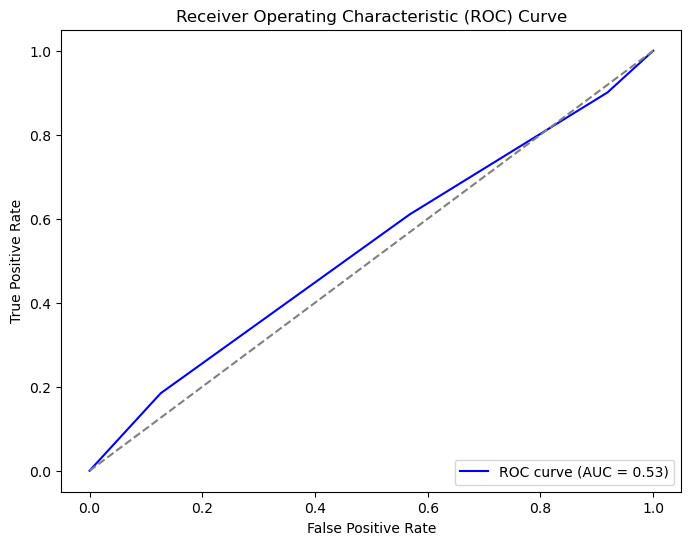

In [51]:
# 创建一个K近邻分类器实例，设置邻居数为3
knn3 = KNeighborsClassifier(n_neighbors=3)  # n_neighbors=3表示使用3个最近邻来进行分类

# 使用训练数据拟合K近邻分类器，并对测试数据进行预测
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)  # 先拟合训练数据（X_train, L_train），再对测试数据（X_test）进行预测

# 计算混淆矩阵
conf_matrix = confusion_matrix(L_test, knn3_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])

# 设置图表样式并显示混淆矩阵
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("KNN Confusion Matrix", fontsize=14)
plt.show()

# 计算预测的概率（这是绘制ROC曲线所需的）
knn3_prob = knn3.predict_proba(X_test)[:, 1]  # 选择预测为 'Up' 类的概率

# 计算 ROC 曲线的数据
fpr, tpr, _ = roc_curve(L_test == 'Up', knn3_prob)

# 计算 AUC
roc_auc = roc_auc_score(L_test == 'Up', knn3_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 比较逻辑回归、LDA、QDA、KNN

In [53]:
# 逻辑回归模型准确率
logreg_accuracy = np.mean(labels == L_test)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.2f}")  # 逻辑回归准确率

# LDA模型准确率
lda_accuracy = np.mean(lda_pred == L_test)
print(f"LDA Accuracy: {lda_accuracy:.2f}")  # LDA准确率

# QDA模型准确率
qda_accuracy = np.mean(qda_pred == L_test)
print(f"QDA Accuracy: {qda_accuracy:.2f}")  # QDA准确率

# KNN模型准确率
knn_accuracy = np.mean(knn3_pred == L_test)
print(f"KNN Accuracy: {knn_accuracy:.2f}")  # KNN准确率


Logistic Regression Accuracy: 0.56
LDA Accuracy: 0.56
QDA Accuracy: 0.60
KNN Accuracy: 0.53
